In [1]:
import lightning.pytorch as pl
import torch
import torch.nn as nn
import logging
import anndata as ad
import numpy as np
import os

from protoplast.scrna.anndata.trainer import RayTrainRunner
from protoplast.scrna.anndata.torch_dataloader import DistributedAnnDataset

from sklearn.decomposition import PCA, IncrementalPCA

✓ Applied AnnDataFileManager patch, AnnData cannot be imported after the patch!
✓ Applied AnnDataFileManager patch, AnnData cannot be imported after the patch!


## Run IncrementalPCA with PROTOplast 

### Class Description

The class **`IncrementalPCAlm(pl.LightningModule)`** replicates the [**`IncrementalPCA`** algorithm from *scikit-learn*](https://github.com/scikit-learn/scikit-learn/blob/b24c328a30/sklearn/decomposition/_incremental_pca.py#L21). However, instead of running entirely in **RAM**, it processes data in **batches on the GPU**. In addition, it supports **checkpoint saving and restoration** during **PyTorch Lightning** training

This implementation is based on the **`perturb_mean`** module from the [**ArcInstitute/state** repository](https://github.com/ArcInstitute/state/blob/b6d26731e41d78c8c789d6973fe3d7db7853e9ad/src/state/tx/models/perturb_mean.py)

**Here is the summary:**
- Each batch updates the running mean, variance, and principal components using SVD.
- After training, the model can project new data into a lower-dimensional PCA space.
- All learned PCA parameters (like components and mean) are saved in a checkpoint for later use.
- A dummy optimizer is included only to make PyTorch Lightning’s training loop run correctly.

In [2]:
# define the lightningmodule
logger = logging.getLogger(__name__)
class IncrementalPCAlm(pl.LightningModule):
    def __init__(self,
                 n_components=None,        # Optional[int] | None
                 whiten=False,             # bool
                 copy=True,                # bool
                 batch_size=None):         # Optional[int] | None
        """
        Parameters from original class
        ----------
        n_components : int or None, default=None  
            Number of principal components to keep.  
            If None, it will be set to `min(n_samples, n_features)` 
            during the first `partial_fit` call.

        whiten : bool, default=False  
            When True (False by default) the ``components_`` vectors are divided
            by ``n_samples`` times ``components_`` to ensure uncorrelated outputs
            with unit component-wise variances.

        copy : bool, default=True  
            If False, input data `X` may be overwritten to save memory.  
            This is not always safe for general use.

        batch_size : int or None, default=None  
            Size of the minibatches for incremental fitting.  
            If None, the value is inferred as `5 * n_features`, balancing 
            approximation accuracy and memory consumption.
        """
        super().__init__()
        self.save_hyperparameters()

        self.n_components = n_components
        self.whiten = whiten
        self.copy = copy
        self.batch_size = batch_size
        self.dummy_param = nn.Parameter(torch.zeros(1))
    
    def partial_fit(self, X):
        """
        Incremental update for PCA from one batch X.
        Assumptions:
        - X is a dense float tensor of shape (n_samples, n_features).
        - n_features must remain the same across calls.
        Returns
        self : IncrementalPCAlm
        """
    
        # copy from sklearn
        n_samples, n_features = X.shape
        first_pass = not hasattr(self, "components_")


        if first_pass:
            self.components_ = None


        if self.n_components is None:
            if self.components_ is None:
                self.n_components_ = min(n_samples, n_features)
            else:
                self.n_components_ = self.components_.shape[0]
        elif not self.n_components <= n_features:
            raise ValueError(
                "n_components=%r invalid for n_features=%d, need "
                "more rows than columns for IncrementalPCA "
                "processing" % (self.n_components, n_features)
            )
        elif self.n_components > n_samples and first_pass:
            raise ValueError(
                f"n_components={self.n_components} must be less or equal to "
                f"the batch number of samples {n_samples} for the first "
                "partial_fit call."
            )
        else:
            self.n_components_ = self.n_components


        if (self.components_ is not None) and (
            self.components_.shape[0] != self.n_components_
        ):
            raise ValueError(
                "Number of input features has changed from %i "
                "to %i between calls to partial_fit! Try "
                "setting n_components to a fixed value."
                % (self.components_.shape[0], self.n_components_)
            )

        # This is the first partial_fit
        if not hasattr(self, "n_samples_seen_"):
            self.n_samples_seen_ = 0
            # sklearn initializes mean_/var_ to 0.0 then updates; we initialize tensors directly
            self.mean_ = torch.zeros(n_features, dtype=X.dtype, device=X.device)
            self.var_  = torch.zeros(n_features, dtype=X.dtype, device=X.device)

        # This code preserves the original incremental mean and variance update formulas from scikit-learn, 
        ## differing only by explicitly computing the current batch’s mean and variance instead of using _incremental_mean_and_var.
        batch_mean = X.mean(dim=0)
        batch_var  = X.var(dim=0, unbiased=False)

        if self.n_samples_seen_ == 0:
            col_mean = batch_mean
            col_var = batch_var
            n_total_samples = n_samples
        else:
            last_sample_count = self.n_samples_seen_
            n_total_samples = last_sample_count + n_samples
            delta = batch_mean - self.mean_
            col_mean = self.mean_ + delta * (n_samples / n_total_samples)
            col_var = (
                (self.var_ * last_sample_count)
                + (batch_var * n_samples)
                + delta.pow(2) * (last_sample_count * n_samples / n_total_samples)
            ) / n_total_samples

        # it preserves the same logic as scikit-learn but uses PyTorch tensors and GPU-safe operations
        if self.n_samples_seen_ == 0:
            Xc = X - col_mean
        else:
            col_batch_mean = batch_mean
            Xc = X - col_batch_mean
            scale_val = (self.n_samples_seen_ / n_total_samples) * n_samples
            scale = torch.sqrt(torch.tensor(scale_val, dtype=X.dtype, device=X.device))
            mean_correction = scale * (self.mean_ - col_batch_mean)


            top = self.singular_values_.unsqueeze(1) * self.components_
            Xc = torch.vstack((top, Xc, mean_correction.unsqueeze(0)))

        # This replaces SciPy’s SVD with PyTorch’s GPU-based version (Vh is equivalent to Vt in scikit-learn)
        U, S, Vh = torch.linalg.svd(Xc, full_matrices=False)

        # from sklearn: explained variance and ratio
        S2 = S.pow(2)
        explained_variance = S2 / (n_total_samples - 1)
        explained_variance_ratio = S2 / (col_var * n_total_samples).sum()

        # from sklearn: commit updated state (use exact attribute names)
        self.components_ = Vh[: self.n_components_, :]           # Vh in torch plays Vt in sklearn
        self.singular_values_ = S[: self.n_components_]
        self.mean_ = col_mean
        self.var_  = col_var
        self.explained_variance_ = explained_variance[: self.n_components_]
        self.explained_variance_ratio_ = explained_variance_ratio[: self.n_components_]

        if (self.n_components_ not in (n_samples, n_features)
                and explained_variance.numel() > self.n_components_):
            self.noise_variance_ = float(explained_variance[self.n_components_:].mean().item())
        else:
            self.noise_variance_ = 0.0

        self.n_samples_seen_ = int(n_total_samples)
        return self
        
    def transform(self, X: torch.Tensor) -> torch.Tensor:
        """
        Project X onto the principal components learned by partial_fit.

        Mirrors sklearn.IncrementalPCA.transform (dense-only here):
        X_new = (X - mean_) @ components_.T
        if whiten: X_new /= sqrt(explained_variance_)

        Parameters
        ----------
        X : torch.Tensor of shape (n_samples, n_features)

        Returns
        -------
        X_new : torch.Tensor of shape (n_samples, n_components_)
        """

        # Center input by the learned per-feature mean
        X_centered = X - self.mean_  # (n_samples, n_features)

        # Linear projection onto right singular vectors (principal axes)
        X_new = X_centered @ self.components_.T  # (n_samples, n_components_)

        # from basePCA: Whitening: divide each PC score by sqrt(explained_variance_)
        # Note: This matches sklearn, which uses sqrt of explained_variance_ (not singular_values_)
        if getattr(self, "whiten", False):
            X_new = X_new / torch.sqrt(self.explained_variance_)

        return X_new
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Lightning forward pass: alias to transform for convenience.
        """
        return self.transform(X)
        
    def training_step(self, batch, batch_idx):
        X = batch if torch.is_tensor(batch) else batch["X"]
        with torch.no_grad():
            self.partial_fit(X)
        # return empty loss
        return self.dummy_param.sum() * 0
    
    def configure_optimizers(self):
        return torch.optim.SGD([self.dummy_param], lr=0.0)

    def on_save_checkpoint(self, checkpoint):
        """
        Save all Incremental PCA state into the Lightning checkpoint.
        Mirrors the style of PerturbMean's save logic.
        """
        super().on_save_checkpoint(checkpoint)

        # Convert tensors to CPU NumPy arrays for serialization
        tensor_keys = [
            "components_",
            "singular_values_",
            "mean_",
            "var_",
            "explained_variance_",
            "explained_variance_ratio_",
        ]
        for k in tensor_keys:
            if hasattr(self, k):
                v = getattr(self, k)
                checkpoint[k] = v.detach().cpu().numpy()

        # Scalars / counters
        checkpoint["noise_variance_"] = float(getattr(self, "noise_variance_", 0.0))
        checkpoint["n_samples_seen_"] = int(getattr(self, "n_samples_seen_", 0))

        # Ensure n_components_ is stored (fall back to ctor arg if first batch not seen)
        n_comp = getattr(self, "n_components_", None)
        if n_comp is None:
            n_comp = self.n_components if self.n_components is not None else 0
        checkpoint["n_components_"] = int(n_comp)

        logger.info(
            "IncrementalPCA: Saved components/mean/var/EV/EVR (+noise_var, n_seen, n_components_) to checkpoint."
        )

    def on_load_checkpoint(self, checkpoint):
        """
        Restore all Incremental PCA state from the Lightning checkpoint.
        Mirrors the style of PerturbMean's load logic.
        """
        super().on_load_checkpoint(checkpoint)

        device = getattr(self, "device", torch.device("cpu"))
        to_tensor = lambda x: torch.tensor(x, dtype=torch.float32, device=device)

        # Load tensors if present; warn if a critical one is missing
        if "components_" in checkpoint:
            self.components_ = to_tensor(checkpoint["components_"])
            logger.info(f"IncrementalPCA: Loaded components_ with shape {tuple(self.components_.shape)}")
        else:
            logger.warning("IncrementalPCA: components_ not found in checkpoint.")

        if "singular_values_" in checkpoint:
            self.singular_values_ = to_tensor(checkpoint["singular_values_"])
        if "mean_" in checkpoint:
            self.mean_ = to_tensor(checkpoint["mean_"])
        else:
            logger.warning("IncrementalPCA: mean_ not found in checkpoint. Transform will fail until fitted.")
        if "var_" in checkpoint:
            self.var_ = to_tensor(checkpoint["var_"])
        if "explained_variance_" in checkpoint:
            self.explained_variance_ = to_tensor(checkpoint["explained_variance_"])
        if "explained_variance_ratio_" in checkpoint:
            self.explained_variance_ratio_ = to_tensor(checkpoint["explained_variance_ratio_"])

        # Load scalars / counters
        self.noise_variance_ = float(checkpoint.get("noise_variance_", 0.0))
        self.n_samples_seen_ = int(checkpoint.get("n_samples_seen_", 0))

        # Keep n_components_ consistent for transform/inverse_transform
        self.n_components_ = int(checkpoint.get("n_components_", self.n_components or 0))

        logger.info(
            f"IncrementalPCA: Loaded n_components_={self.n_components_}, "
            f"n_samples_seen_={self.n_samples_seen_}, noise_variance_={self.noise_variance_}"
        )

In [3]:
def pca_metadata_cb(adata: ad.AnnData, metadata: dict) -> None:
    metadata["n_features"] = int(adata.var.shape[0])
    metadata["n_components"] = 10 # number of components need to be smaller or equal than batch size 

In [4]:
class DistributedPCAAnnDataset(DistributedAnnDataset):
    """
    Dataset for Incremental PCA (unsupervised).
    Returns {'X': <tensor>} so IncrementalPCAlm.on_fit_start can consume it.
    """

    def transform(self, start: int, end: int):
        X = super().transform(start, end)  # shape: (end - start, n_features)
        return {"X": X}

In [5]:
file_paths = ["/mnt/hdd1/dung/tahoe100/tahoe100_data/plate3_2k-obs.h5ad"]
batch_size = 20
test_size = 0.0
val_size = 0.0

In [6]:
pcarunner_trainer = RayTrainRunner(
    Model=IncrementalPCAlm,
    Ds=DistributedPCAAnnDataset,
    model_keys=["n_components", "whiten", "copy", "batch_size"],  
    metadata_cb=pca_metadata_cb,
)

2025-10-17 13:22:11,641	INFO worker.py:1951 -- Started a local Ray instance.
2025-10-17 13:22:11,861	INFO packaging.py:588 -- Creating a file package for local module '/mnt/hdd1/dung/protoplast-ml-example'.
2025-10-17 13:22:11,993	WARNING packaging.py:430 -- File /mnt/hdd1/dung/protoplast-ml-example/.git/modules/submodules/SIMS/objects/pack/pack-682433dc4cf8becc2b44606f464dde9068565261.pack is very large (34.70MiB). Consider adding this file to the 'excludes' list to skip uploading it: `ray.init(..., runtime_env={'excludes': ['/mnt/hdd1/dung/protoplast-ml-example/.git/modules/submodules/SIMS/objects/pack/pack-682433dc4cf8becc2b44606f464dde9068565261.pack']})`
2025-10-17 13:22:12,217	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_8d6595e3d0449e8a.zip' (70.06MiB) to Ray cluster...
2025-10-17 13:22:12,691	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_8d6595e3d0449e8a.zip'.
(raylet) warning: `VIRTUAL_ENV=/mnt/hdd1/dung/protoplast-ml-example/.venv`

(TrainTrainable pid=178468) ✓ Applied AnnDataFileManager patch, AnnData cannot be imported after the patch!
(TrainTrainable pid=178468) ✓ Applied AnnDataFileManager patch, AnnData cannot be imported after the patch!


(raylet) warning: `VIRTUAL_ENV=/mnt/hdd1/dung/protoplast-ml-example/.venv` does not match the project environment path `.venv` and will be ignored; use `--active` to target the active environment instead
(RayTrainWorker pid=179891) Setting up process group for: env:// [rank=0, world_size=1]
(TorchTrainer pid=178468) Started distributed worker processes: 
(TorchTrainer pid=178468) - (node_id=7c1dec74bc15d60dbac031667ba59d86f802f99807acabf73cacecd7, ip=192.168.1.226, pid=179891) world_rank=0, local_rank=0, node_rank=0


(RayTrainWorker pid=179891) ✓ Applied AnnDataFileManager patch, AnnData cannot be imported after the patch!
(RayTrainWorker pid=179891) ✓ Applied AnnDataFileManager patch, AnnData cannot be imported after the patch!


(RayTrainWorker pid=179891) 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
(RayTrainWorker pid=179891) GPU available: True (cuda), used: True
(RayTrainWorker pid=179891) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=179891) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=179891) /tmp/ray/session_2025-10-17_13-22-07_867569_168656/runtime_resources/working_dir_files/_ray_pkg_8d6595e3d0449e8a/.venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /mnt/hdd1/dung/protoplast-ml-example/.venv/lib/pyth ...
(RayTrainWorker pid=179891) /tmp/ray/session_2025-10-17_13-22-07_867569_168656/runtime_resources/workin

(RayTrainWorker pid=179891) =========Starting the training on 0 with num threads: 4=========


(RayTrainWorker pid=179891) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(RayTrainWorker pid=179891) 
(RayTrainWorker pid=179891)   | Name         | Type | Params | Mode
(RayTrainWorker pid=179891) ---------------------------------------------
(RayTrainWorker pid=179891)   | other params | n/a  | 1      | n/a 
(RayTrainWorker pid=179891) ---------------------------------------------
(RayTrainWorker pid=179891) 1         Trainable params
(RayTrainWorker pid=179891) 0         Non-trainable params
(RayTrainWorker pid=179891) 1         Total params
(RayTrainWorker pid=179891) 0.000     Total estimated model params size (MB)
(RayTrainWorker pid=179891) 0         Modules in train mode
(RayTrainWorker pid=179891) 0         Modules in eval mode
(RayTrainWorker pid=179891) /tmp/ray/session_2025-10-17_13-22-07_867569_168656/runtime_resources/working_dir_files/_ray_pkg_8d6595e3d0449e8a/.venv/lib/python3.11/site-packages/torch/distributed/distributed_c10d.py:4807: UserWarning: No device id is provide

Epoch 0:   0%|          | 0/64 [00:00<?, ?it/s] 


(RayTrainWorker pid=179891) /tmp/ray/session_2025-10-17_13-22-07_867569_168656/runtime_resources/working_dir_files/_ray_pkg_8d6595e3d0449e8a/submodules/protoplast/src/protoplast/scrna/anndata/torch_dataloader.py:130: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
(RayTrainWorker pid=179891)   return torch.sparse_csr_tensor(
(RayTrainWorker pid=179891) /tmp/ray/session_2025-10-17_13-22-07_867569_168656/runtime_resources/working_dir_files/_ray_pkg_8d6595e3d0449e8a/submodules/protoplast/src/protoplast/scrna/anndata/torch_dataloader.py:130: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/sr

Epoch 0: 100%|██████████| 64/64 [00:02<00:00, 22.46it/s, v_num=0]


(RayTrainWorker pid=179891) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/dtran/training_results/TorchTrainer_2025-10-17_13-22-16/TorchTrainer_4cfbc_00000_0_2025-10-17_13-22-16/checkpoint_000000)
(RayTrainWorker pid=179891) `Trainer.fit` stopped: `max_epochs=1` reached.
(RayTrainWorker pid=179891) [rank0]:[W1017 13:22:56.248694145 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


In [7]:
result = pcarunner_trainer.train(file_paths,
                                 batch_size,  # 20
                                 test_size,  # 0.0
                                 val_size, # 0.0
                                 result_storage_path = "~/training_results",
                                )

Setting thread_per_worker to half of the available CPUs capped at 4
Using 1 workers with {'CPU': 4} each
=========Length of val_split 0 length of test_split 0 length of train_split 6
=========Warning: 0.3333333333333333 of data is dropped
=========Length of after dropping remainder val_split 0 length of test_split 0 length of train_split 4
Data splitting time: 0.10 seconds
Spawning Ray worker and initiating distributed training


2025-10-17 13:22:16,535	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-10-17 13:22:16 (running for 00:00:00.13)
Using FIFO scheduling algorithm.
Logical resource usage: 0/96 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-10-17_13-22-07_867569_168656/artifacts/2025-10-17_13-22-16/TorchTrainer_2025-10-17_13-22-16/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2025-10-17 13:22:21 (running for 00:00:05.16)
Using FIFO scheduling algorithm.
Logical resource usage: 0/96 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-10-17_13-22-07_867569_168656/artifacts/2025-10-17_13-22-16/TorchTrainer_2025-10-17_13-22-16/driver_artifacts
Number of trials: 1/1 (1 PENDING)


== Status ==
Current time: 2025-10-17 13:22:26 (running for 00:00:10.20)
Using FIFO scheduling algorithm.
Logical resource usage: 5.0/96 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-10-17_13-22-07_867569_168656/artifacts/2025-10-17_13-22-16

2025-10-17 13:22:55,571	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/dtran/training_results/TorchTrainer_2025-10-17_13-22-16' in 0.0081s.
2025-10-17 13:22:55,575	INFO tune.py:1041 -- Total run time: 39.04 seconds (38.88 seconds for the tuning loop).


== Status ==
Current time: 2025-10-17 13:22:55 (running for 00:00:38.89)
Using FIFO scheduling algorithm.
Logical resource usage: 5.0/96 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-10-17_13-22-07_867569_168656/artifacts/2025-10-17_13-22-16/TorchTrainer_2025-10-17_13-22-16/driver_artifacts
Number of trials: 1/1 (1 TERMINATED)




## Load checkpoint to transfrom data

In [8]:
ckpt_path = os.path.join(result.checkpoint.path, "checkpoint.ckpt")

In [9]:
ckpt_path

'/home/dtran/training_results/TorchTrainer_2025-10-17_13-22-16/TorchTrainer_4cfbc_00000_0_2025-10-17_13-22-16/checkpoint_000000/checkpoint.ckpt'

In [10]:
pca = IncrementalPCAlm.load_from_checkpoint(ckpt_path)
pca.eval()

IncrementalPCAlm()

**Batch size = 20, 2000 rows but 64 steps --> 1280 rows**

In [11]:
print("n_components_:", pca.n_components_)
print("n_samples_seen_:", pca.n_samples_seen_)
print("components shape:", pca.components_.shape)
print("explained_variance_ratio sum:", pca.explained_variance_ratio_.sum().item())

n_components_: 10
n_samples_seen_: 1280
components shape: torch.Size([10, 62710])
explained_variance_ratio sum: 0.8779616951942444


In [12]:
# Move all internal PCA tensors to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for attr in ["mean_", "components_", "explained_variance_", "explained_variance_ratio_",
              "singular_values_", "var_"]:
    if hasattr(pca, attr):
        tensor = getattr(pca, attr)
        if isinstance(tensor, torch.Tensor):
            setattr(pca, attr, tensor.to(device))

In [13]:
# load subset plate 3
adata = ad.read_h5ad(
    '/mnt/hdd1/dung/tahoe100/tahoe100_data/plate3_2k-obs.h5ad',
    backed="r"
)

n_obs = adata.n_obs
n_obs

2000

In [14]:
# Define the data range to load (0 → n_obs), set the main data key "X", and select GPU if available
# Create a DistributedAnnDataset that streams mini-batches efficiently for large-scale GPU processing
indices = [[(0, n_obs)]]
metadata = {}
sparse_key = "X"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = DistributedAnnDataset(
    file_paths=file_paths,
    indices=indices,
    metadata=metadata,
    sparse_key=sparse_key,
    mini_batch_size=batch_size,
)

In [15]:
# Move the trained PCA model to the target device (GPU or CPU)
# Disable gradient tracking for inference to save memory
# Iterate over the dataset batch by batch
#   - Convert sparse tensors to dense if needed
#   - Move each batch to the device asynchronously
#   - Run the PCA model to get the transformed output (Z)
#   - Store results on CPU to free GPU memory
# Print progress every 100 batches to monitor shapes
# Finally, concatenate all batch outputs into a single tensor and print its shape

pca = pca.to(device)

preds = []

with torch.no_grad():
    for i, X in enumerate(dataset):
        if X.is_sparse or getattr(X, "is_sparse_csr", False):
            X = X.to_dense()
        X = X.to(device, non_blocking=True)
        Z = pca(X)
        preds.append(Z.cpu())


pred = torch.cat(preds, dim=0)
print(pred.shape)

/mnt/hdd1/dung/protoplast-ml-example/submodules/protoplast/src/protoplast/scrna/anndata/torch_dataloader.py:130: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(


torch.Size([2000, 10])


## Use IncrementalPCA from sklearn

In [16]:
# load full subset plate 3
adata = ad.read_h5ad(
    '/mnt/hdd1/dung/tahoe100/tahoe100_data/plate3_2k-obs.h5ad')
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2185374 stored elements and shape (2000, 62710)>

In [17]:
n_components = 10
ipca = IncrementalPCA(n_components=n_components, batch_size=20)
X_ipca = ipca.fit_transform(adata.X)
X_ipca 

array([[-49.77487077, -12.01619474,  -6.92070932, ...,   0.75223352,
          2.80024282,   0.65507282],
       [-60.31321549,  -2.0784208 , -14.47853063, ...,  -5.59866123,
         -2.91334779,   3.4672402 ],
       [-41.76954858, -23.72185019,  -2.46344859, ...,  -5.70556231,
         -1.9203904 ,  -1.23891665],
       ...,
       [ 17.34332576,  46.68288008, -19.48573782, ...,  -5.53450521,
          5.43952264,   5.71698531],
       [  0.39764955,  30.83655091,  -6.11114563, ...,  -7.08662903,
          5.70962253,  -2.31416498],
       [-59.19563955,  -8.01704325,  -4.23143914, ...,   1.46030694,
         -1.22334235,   0.33231682]], shape=(2000, 10))

In [18]:
print("components:", ipca.components_.shape)          
print("mean:", ipca.mean_.shape)                  
print("explained variance ratio sum:", ipca.explained_variance_ratio_.sum())

components: (10, 62710)
mean: (62710,)
explained variance ratio sum: 0.8643136257943519


## Compare result between pred and PCA from sklearn

In [19]:
# explain variance
print("explained_variance_ratio sum using protoplast:", pca.explained_variance_ratio_.sum().item())
print("explained variance ratio sum using sklearn:", ipca.explained_variance_ratio_.sum())

explained_variance_ratio sum using protoplast: 0.8779617547988892
explained variance ratio sum using sklearn: 0.8643136257943519


In [20]:
# protoplast
for i, var in enumerate(pca.explained_variance_):
    print(f"Component {i+1}: variance = {var.item():.6f}")

Component 1: variance = 11603.109375
Component 2: variance = 1802.824341
Component 3: variance = 323.876770
Component 4: variance = 142.942871
Component 5: variance = 100.278931
Component 6: variance = 68.006332
Component 7: variance = 64.209496
Component 8: variance = 38.265137
Component 9: variance = 35.445488
Component 10: variance = 22.524128


In [21]:
# sklearn
for i, var in enumerate(ipca.explained_variance_):
    print(f"Component {i+1}: variance = {var.item():.6f}")

Component 1: variance = 9995.452743
Component 2: variance = 1681.837501
Component 3: variance = 250.567777
Component 4: variance = 129.349194
Component 5: variance = 101.511644
Component 6: variance = 60.780132
Component 7: variance = 54.624790
Component 8: variance = 32.390319
Component 9: variance = 26.173909
Component 10: variance = 21.330523


In [22]:
# protoplast
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Component {i+1}: ratio = {ratio.item():.6f}")

Component 1: ratio = 0.717326
Component 2: ratio = 0.111454
Component 3: ratio = 0.020023
Component 4: ratio = 0.008837
Component 5: ratio = 0.006199
Component 6: ratio = 0.004204
Component 7: ratio = 0.003970
Component 8: ratio = 0.002366
Component 9: ratio = 0.002191
Component 10: ratio = 0.001392


In [23]:
# sklearn
for i, ratio in enumerate(ipca.explained_variance_ratio_):
    print(f"Component {i+1}: ratio = {ratio.item():.6f}")

Component 1: ratio = 0.699303
Component 2: ratio = 0.117665
Component 3: ratio = 0.017530
Component 4: ratio = 0.009050
Component 5: ratio = 0.007102
Component 6: ratio = 0.004252
Component 7: ratio = 0.003822
Component 8: ratio = 0.002266
Component 9: ratio = 0.001831
Component 10: ratio = 0.001492


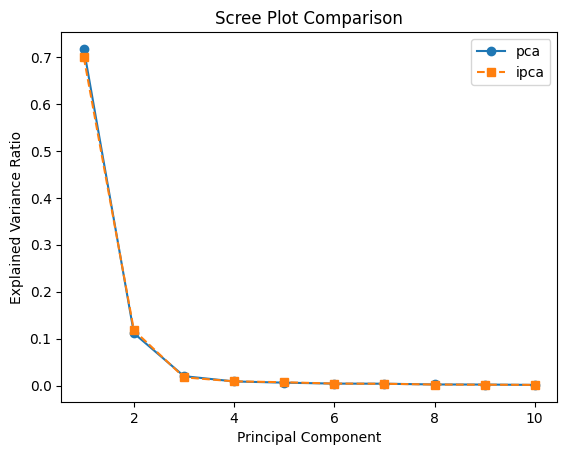

In [24]:
import matplotlib.pyplot as plt

ratios1 = [0.717326, 0.111454, 0.020023, 0.008837, 0.006199,
           0.004204, 0.003970, 0.002366, 0.002191, 0.001392]
ratios2 = [0.699303, 0.117665, 0.017530, 0.009050, 0.007102,
           0.004252, 0.003822, 0.002266, 0.001831, 0.001492]

plt.plot(range(1,11), ratios1, 'o-', label='pca')
plt.plot(range(1,11), ratios2, 's--', label='ipca')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot Comparison')
plt.legend()
plt.show()

The scree plot shows that the **1st PC explains approximately 70% of the total variance**, followed by the **2nd component with around 11%**, while the remaining components each contribute only a small fraction (<2%) of the variance. **The curves from Incremental PCA running with PROTOplast and Incremental PCA from sklearn almost completely overlap**, indicating that both methods capture the same underlying data structure with minimal numerical differences

In [25]:
# convert
Z_light = pred.numpy()
Z_light

array([[-51.12952   ,  -5.7999043 ,   6.789272  , ...,  -0.12457524,
          1.373474  ,  -1.2944874 ],
       [-62.071934  ,   3.782553  ,  13.692977  , ...,  -3.9471214 ,
         -2.1766663 ,   2.2718616 ],
       [-42.674145  , -17.226257  ,   1.8793188 , ...,  -5.7448387 ,
         -0.68625647,   1.6748312 ],
       ...,
       [ 13.247725  ,  56.11907   ,  14.36434   , ...,  -2.6307726 ,
          3.0633924 ,  -3.5213056 ],
       [ -3.05303   ,  39.24943   ,   1.6652731 , ...,  -8.3687525 ,
          5.591614  ,  -0.65801555],
       [-60.816666  ,  -2.1650913 ,   3.0534985 , ...,   1.9720454 ,
         -0.9452772 ,  -0.71887076]], shape=(2000, 10), dtype=float32)

In [26]:
Z_sklearn = X_ipca
Z_sklearn

array([[-49.77487077, -12.01619474,  -6.92070932, ...,   0.75223352,
          2.80024282,   0.65507282],
       [-60.31321549,  -2.0784208 , -14.47853063, ...,  -5.59866123,
         -2.91334779,   3.4672402 ],
       [-41.76954858, -23.72185019,  -2.46344859, ...,  -5.70556231,
         -1.9203904 ,  -1.23891665],
       ...,
       [ 17.34332576,  46.68288008, -19.48573782, ...,  -5.53450521,
          5.43952264,   5.71698531],
       [  0.39764955,  30.83655091,  -6.11114563, ...,  -7.08662903,
          5.70962253,  -2.31416498],
       [-59.19563955,  -8.01704325,  -4.23143914, ...,   1.46030694,
         -1.22334235,   0.33231682]], shape=(2000, 10))

In [27]:
# mse
((Z_light - Z_sklearn)**2).mean()

np.float64(146.4246352515832)

**The discrepancy may be caused by differences in batch splitting, which can slightly shift the data space along certain axes**

In [21]:
# correlation
corr = np.corrcoef(Z_light.flatten(), Z_sklearn.flatten())
print(corr)

[[1.        0.9410407]
 [0.9410407 1.       ]]


**The correlation coefficient between two pipelines was 0.94, indicating a strong linear relationship between the two results**

In [22]:
for i in range(Z_light.shape[1]):
    r = np.corrcoef(Z_light[:, i], Z_sklearn[:, i])[0, 1]
    print(f"PC{i+1}: corr = {r:.3f}")


PC1: corr = 1.000
PC2: corr = 0.994
PC3: corr = -0.986
PC4: corr = 0.838
PC5: corr = 0.769
PC6: corr = 0.935
PC7: corr = -0.944
PC8: corr = 0.943
PC9: corr = 0.897
PC10: corr = 0.248


- **PC3 and PC7 have reversed directions, but their high correlation coefficients indicate that they still match well.** 
- **PC10, being the last component, captures very little variance and is therefore more affected by noise.**

In [28]:
from scipy.linalg import orthogonal_procrustes

R, _ = orthogonal_procrustes(Z_light, Z_sklearn)
Z_aligned = Z_light @ R
mse_aligned = ((Z_aligned - Z_sklearn)**2).mean()
corr_after = np.corrcoef(Z_aligned.flatten(), Z_sklearn.flatten())[0,1]

print("MSE after alignment:", mse_aligned)
print("Overall corr after alignment:", corr_after)

MSE after alignment: 11.692814665172907
Overall corr after alignment: 0.9955322817228878


After applying alignment, the mean squared error decreased to 11.69, and the overall correlation increased to 0.9955. This demonstrates that both PCA implementations capture the same subspace, differing only by a rotational transformation